In [1]:
import pandas as pd
import numpy as np
from math import *
from sklearn import model_selection, metrics, dummy

import matplotlib.pyplot as plt

In [2]:
from sklearn.ensemble import RandomForestRegressor

In [3]:
import pickle

with open("./data/pickle", 'rb') as f:
    data_X, data_Y = pickle.load(f)

In [4]:
# 0 pour les données sans star, 1 pour energystar
data_X = data_X[0]
data_Y = data_Y[0]

In [5]:
col_num = list(data_X.select_dtypes(include=['float', 'int', 'uint8']).columns)

In [6]:
data_Y.describe()

,Energy_Y,CO2_Y
count,1540.000000,1540.000000
mean,14.875836,3.999176
std,1.420562,1.403629
min,0.693147,0.182322
25%,14.001715,3.061635
50%,14.772204,3.920486
75%,15.759488,4.929210
max,19.495993,9.418099


In [7]:
from sklearn.model_selection import KFold

In [8]:
kf = KFold(n_splits=8)

In [9]:
dum = dummy.DummyRegressor(strategy='median')

score_final = {'R2':0, 'RMSE':0, 'MAE':0}

for train, test in kf.split(data_X):
    # Entraînement
    dum.fit(data_X.iloc[train], data_Y.iloc[train])

    # Prédiction sur le jeu de test
    y_pred = dum.predict(data_X.iloc[test])

    
    y_test = data_Y.iloc[test]
    
    # Evaluate
    score = metrics.r2_score(y_test, y_pred)
    print('R2 : ', score)
    score_final['R2'] += abs(score)
    
    score = metrics.mean_squared_error(y_test, y_pred, squared=True)
    #print('RMSE : ', score)
    score_final['RMSE'] += score
    
    score = metrics.mean_absolute_error(y_test.applymap(lambda x:max(0, x)), y_pred)
    #print('RMSLE : ', score)
    score_final['MAE'] += score

for k, score in score_final.items():
    print('Score {} final : {}'.format(k, score/kf.get_n_splits()))

R2 :  -0.0034123671742676276
R2 :  -0.00021859425747627892
R2 :  -0.026562726191006636
R2 :  -0.00065737674051769
R2 :  -0.001081107656228597
R2 :  -0.005064740451817706
R2 :  -0.015087853114843841
R2 :  -0.015601236015134745
Score R2 final : 0.00846075020016164
Score RMSE final : 2.003275281632585
Score MAE final : 1.0913013955445685


In [10]:
data_X_tmp = data_X[col_num]

score_final = {'R2':0, 'RMSE':0, 'MAE':0}

best_result = {'R2':0, 'Data':None, 'Target':None}
worst_result = {'R2':1, 'Data':None, 'Target':None}

for train, test in kf.split(data_X_tmp):
    regr = RandomForestRegressor(max_depth=50)
    
    # Entraînement
    regr.fit(data_X_tmp.iloc[train], data_Y.iloc[train])

    # Prédiction sur le jeu de test
    y_pred = regr.predict(data_X_tmp.iloc[test])

    
    y_test = data_Y.iloc[test]
    
    # Evaluate
    score = metrics.r2_score(y_test, y_pred)
    print('R2 : ', score)
    score_final['R2'] += abs(score)
    
    if score > best_result['R2']:
        best_result['R2'] = score
        best_result['Data'] = data_X_tmp.iloc[test]
        best_result['Target'] = [y_test, y_pred]
    
    if score < worst_result['R2']:
        worst_result['R2'] = score
        worst_result['Data'] = data_X_tmp.iloc[test]
        worst_result['Target'] = [y_test, y_pred]
    
    score = metrics.mean_squared_error(y_test, y_pred, squared=True)
    #print('RMSE : ', score)
    score_final['RMSE'] += score
    
    score = metrics.mean_absolute_error(y_test, y_pred)
    #print('RMSLE : ', score)
    score_final['MAE'] += score

for k, score in score_final.items():
    print('Score {} final : {}'.format(k, score/kf.get_n_splits()))

R2 :  0.6705142897033379
R2 :  0.5397329338059915
R2 :  0.7108215340580972
R2 :  0.6957909420847957
R2 :  0.5605668199157946
R2 :  0.7490125103066627
R2 :  0.6991615185541633
R2 :  0.48102312932890234
Score R2 final : 0.6383279597197182
Score RMSE final : 0.7439376293976013
Score MAE final : 0.5678674273847613


In [11]:
# define the model
model = RandomForestRegressor(max_depth=30)
# fit the model
model.fit(data_X[col_num], data_Y['CO2_Y'])
# get importance
importance = model.feature_importances_

for i, v in pd.Series(importance).sort_values(ascending=False).items():
    print('{} : {:.5f}'.format(col_num[i],v))
    
# plot feature importance

PropertyGFATotal : 0.19163
Gas : 0.18003
PropertyGFABuilding(s) : 0.17615
VolumeInside : 0.04687
LargestPropertyUseTypeGFA : 0.04554
Steam : 0.03179
LargestPropertyUseType : 0.02608
Age : 0.02397
PrimaryPropertyType : 0.02362
Type_Non-refrigerated warehouse : 0.02104
SeaProximityLimit : 0.02014
Type_Office : 0.01890
SeaProximity : 0.01861
EquatorProximity : 0.01854
SimpleAddress : 0.01735
ZipCode : 0.01244
PrimaryPropertyType_Supermarket / grocery store : 0.01074
SecondLargestPropertyUseTypeGFA : 0.01045
Type_Hospital (general medical & surgical) : 0.00886
Type_Other : 0.00756
Electricity : 0.00593
Type_Supermarket/grocery store : 0.00589
LonLatGrille : 0.00539
SecondLargestPropertyUseType : 0.00488
ThirdLargestPropertyUseTypeGFA : 0.00459
Type_Parking : 0.00444
Type_Other - recreation : 0.00351
Type_Retail store : 0.00333
PrimaryPropertyType_Self-storage facility : 0.00331
Type_Laboratory : 0.00313
PrimaryPropertyType_Other : 0.00306
Type_Data center : 0.00304
NumberOfPropertyUseTypes

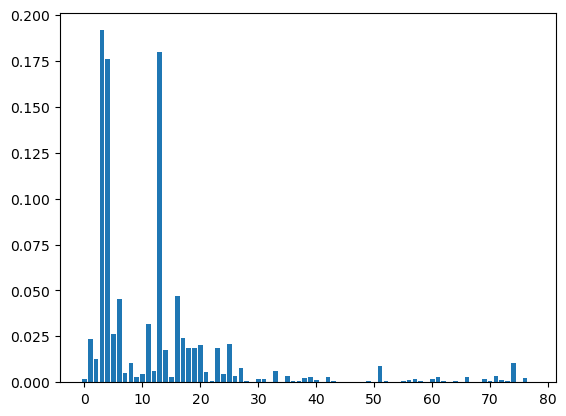

In [12]:
plt.bar([x for x in range(len(importance))], importance)
plt.show()

Gas : 0.12696
Type_Hospital (general medical & surgical) : 0.07757
PropertyGFABuilding(s) : 0.07598
Type_Supermarket/grocery store : 0.07373
Steam : 0.06727
PrimaryPropertyType_Large office : 0.04867
Type_Self-storage facility : 0.04288
PrimaryPropertyType_Supermarket / grocery store : 0.04042
Type_Fitness center/health club/gym : 0.03790
Type_Laboratory : 0.03344
Electricity : 0.02416
Type_Senior care community : 0.02263
Type_Distribution center : 0.02215
PrimaryPropertyType_Restaurant : 0.01856
PropertyGFATotal : 0.01832
Type_Restaurant : 0.01688
Type_Other - recreation : 0.01635
PrimaryPropertyType_Self-storage facility : 0.01575
Type_Non-refrigerated warehouse : 0.01380
Type_Data center : 0.01290
PrimaryPropertyType_Hotel : 0.01149
PrimaryPropertyType_Hospital : 0.01142
PrimaryPropertyType_Laboratory : 0.00951
LargestPropertyUseType : 0.00871
PrimaryPropertyType_Other : 0.00871
Type_Worship facility : 0.00838
Type_Swimming pool : 0.00792
PrimaryPropertyType_Low-rise multifamily : 0

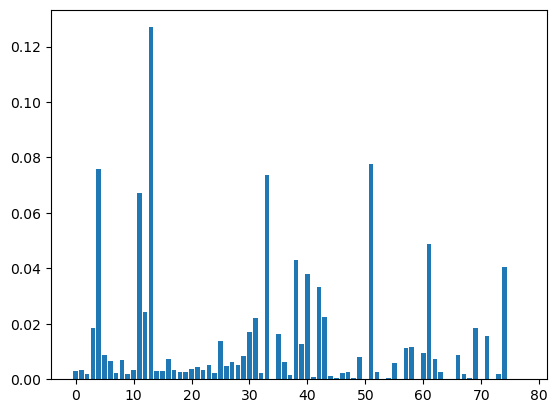

In [13]:
from xgboost import XGBRegressor


# define the model
model = XGBRegressor()
# fit the model
model.fit(data_X[col_num], data_Y['CO2_Y'])
# get importance
importance = model.feature_importances_

for i, v in pd.Series(importance).sort_values(ascending=False).items():
    print('{} : {:.5f}'.format(col_num[i],v))
    
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

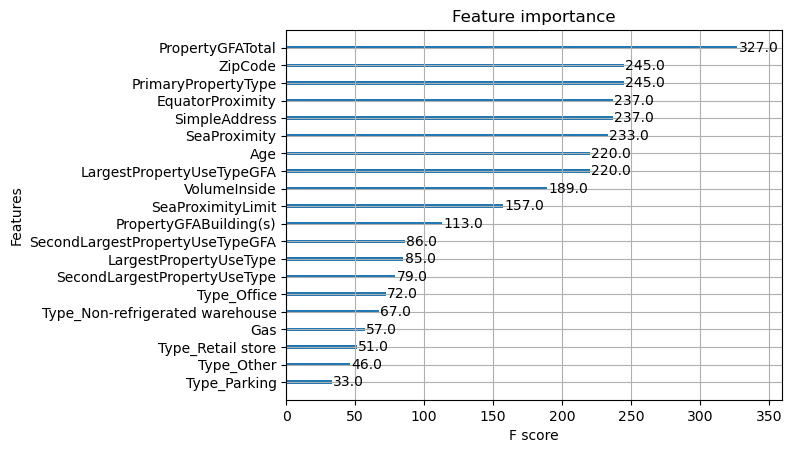

In [14]:
import xgboost as xgb

xgb.plot_importance(model, max_num_features=20)

In [15]:
from sklearn.linear_model import LassoCV, MultiTaskLassoCV
from sklearn.datasets import make_regression


reg = MultiTaskLassoCV(cv=5).fit(data_X[col_num], data_Y)
reg.score(data_X[col_num], data_Y)


0.6978951100753904

In [16]:
data_X_tmp = data_X[col_num]

score_final = {'R2':0, 'RMSE':0, 'MAE':0}

for train, test in kf.split(data_X_tmp):
    regr = MultiTaskLassoCV(cv=4)
    
    # Entraînement
    regr.fit(data_X_tmp.iloc[train], data_Y.iloc[train])

    # Prédiction sur le jeu de test
    y_pred = regr.predict(data_X_tmp.iloc[test])

    
    y_test = data_Y.iloc[test]
    
    # Evaluate
    score = metrics.r2_score(y_test, y_pred)
    print('R2 : ', score)
    score_final['R2'] += abs(score)
    
    score = metrics.mean_squared_error(y_test, y_pred, squared=True)
    #print('RMSE : ', score)
    score_final['RMSE'] += score
    
    score = metrics.mean_absolute_error(y_test.applymap(lambda x:max(0, x)), y_pred)
    #print('RMSLE : ', score)
    score_final['MAE'] += score

for k, score in score_final.items():
    print('Score {} final : {}'.format(k, score/kf.get_n_splits()))

R2 :  0.6693492840008008
R2 :  0.577561078266104
R2 :  0.710581262844923
R2 :  0.6746550411352401
R2 :  0.6683971734645135
R2 :  0.7096326605460075
R2 :  0.5432725741013527
R2 :  0.6433466152336211
Score R2 final : 0.6495994611990703
Score RMSE final : 0.6909791623525428
Score MAE final : 0.5841227900581234


In [17]:
from sklearn.model_selection import GridSearchCV
import time

list_models = []

def grid_search_cv_models(X, y, models, params):
    global list_models
    best_score = 0
    best_model = None
    
    X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.33)

    for model, model_params in zip(models, params):
        gs = GridSearchCV(model, model_params, cv=5, error_score='raise', refit='r2', scoring=['r2', 'neg_root_mean_squared_error', 'neg_mean_absolute_error'])
        
        # Entraîner le modèle sur les données X et y
        gs.fit(X_train, y_train)
        
        
        
        print("\n"*5, str(gs.best_estimator_), '\n')
        
        nom_estimator = str(gs.best_estimator_)
        
        list_models.append({"name":nom_estimator[:nom_estimator.index('(')], "clf":gs.best_estimator_})
        
        tab_cv_result = pd.DataFrame(gs.cv_results_)
        
        print(tab_cv_result[['mean_fit_time', 'mean_score_time', 'mean_test_r2']]) # 'params', 
        
        tab_cv_result = tab_cv_result.loc[tab_cv_result['rank_test_r2']==1]
        
        print("Temps d'entrainement : ", tab_cv_result['mean_fit_time'].to_list()[0])
        print("Temps de prédiction : ", tab_cv_result['mean_score_time'].to_list()[0])
        
        for n, m in [('R2', 'r2'), ('RMSE', 'neg_root_mean_squared_error'), ('MAE', 'neg_mean_absolute_error')]:
            mean = tab_cv_result['mean_test_'+m].to_list()[0]
            std = tab_cv_result['std_test_'+m].to_list()[0]
            
            if n!='R2':
                mean = -mean
                
            print("Score {} : {:.4f} Deviation : {:.4f}".format(n, mean, std))
        
        
        #print(tab_cv_result.columns)
        print('\nTest sur les données restantes :')
        
        start_time = time.time()
        trained_estimator = gs.best_estimator_.fit(X_train, y_train)
        print("Temps d'entrainement : ", time.time() - start_time)
        
        start_time = time.time()
        y_pred = trained_estimator.predict(X_test)
        print("Temps de prédiction : ", time.time() - start_time)
        
        for n, m in [('R2', metrics.r2_score),
                     ('RMSE', metrics.mean_squared_error),
                     ('MAE', metrics.mean_absolute_error)]:
            score = m(y_test, np.abs(y_pred))
            
            if n=='RMSE':
                score = sqrt(score)
            
            print("Score {} : {:.4f}".format(n, score))
        
        # Si le meilleur score de ce modèle est supérieur au meilleur score actuel, le mettre à jour
        if gs.best_score_ > best_score:
            best_score = gs.best_score_
            best_model = gs.best_estimator_
    # Renvoyer le meilleur modèle
    return best_model

In [18]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, BayesianRidge
from sklearn.neighbors import KNeighborsRegressor

# Une liste de modèles
models = [dummy.DummyRegressor(), KNeighborsRegressor(), LassoCV(), RandomForestRegressor(), Ridge(), LinearRegression(), Lasso(), BayesianRidge(), XGBRegressor()]
# Une liste de paramètres pour les modèles correspondants
params = [{'strategy':['mean', 'median']},
          {'n_neighbors':[5, 10, 15, 30], 'weights':['distance']},
          {'cv':[2, 3, 4, 5, 6, 8]},
          {"max_depth": [3, 5, 10, 20, 30, 50, 75, 100]},
          {"alpha": np.arange(0.1, 0.9, 0.01)},
          {},
          {"alpha": np.arange(0.1, 0.9, 0.01)},
          {'alpha_init':[1, 1.4, 1.9],
           'lambda_init': [1e-1, 1e-3, 1e-5]},
          {"learning_rate": [0.10, 0.15, 0.20],
            "max_depth": [3, 4, 5],
            "min_child_weight": [2, 3, 4],
            "gamma":[0.0, 0.05, 0.1],
            "colsample_bytree":[0.3, 0.4]}]


best_model = grid_search_cv_models(data_X[col_num], data_Y['Energy_Y'], models, params)
print("Le meilleur modèle est:", best_model)






 DummyRegressor() 

   mean_fit_time  mean_score_time  mean_test_r2
0            0.0         0.000000     -0.005871
1            0.0         0.003124     -0.012056
Temps d'entrainement :  0.0
Temps de prédiction :  0.0
Score R2 : -0.0059 Deviation : 0.0061
Score RMSE : 1.4514 Deviation : 0.1571
Score MAE : 1.0653 Deviation : 0.0545

Test sur les données restantes :
Temps d'entrainement :  0.0
Temps de prédiction :  0.0
Score R2 : -0.0062
Score RMSE : 1.3411
Score MAE : 1.0760





 KNeighborsRegressor(n_neighbors=30, weights='distance') 

   mean_fit_time  mean_score_time  mean_test_r2
0       0.002907         0.100450      0.087906
1       0.005224         0.083123      0.102109
2       0.007239         0.082423      0.113484
3       0.003617         0.087172      0.120595
Temps d'entrainement :  0.0036165714263916016
Temps de prédiction :  0.08717231750488282
Score R2 : 0.1206 Deviation : 0.0462
Score RMSE : 1.3598 Deviation : 0.1794
Score MAE : 0.9690 Deviation : 0.0510

Test s

In [19]:
def setup_plot():
    plt.rcParams["axes.grid.axis"] ="y"
    plt.rcParams["axes.grid"] = True
    plt.rcParams["legend.fontsize"] = 14
    plt.rc('grid', linestyle="dashed", color='lightgrey', linewidth=1)
    plt.rcParams["xtick.labelsize"] = 15
    plt.rcParams["ytick.labelsize"]  = 15 

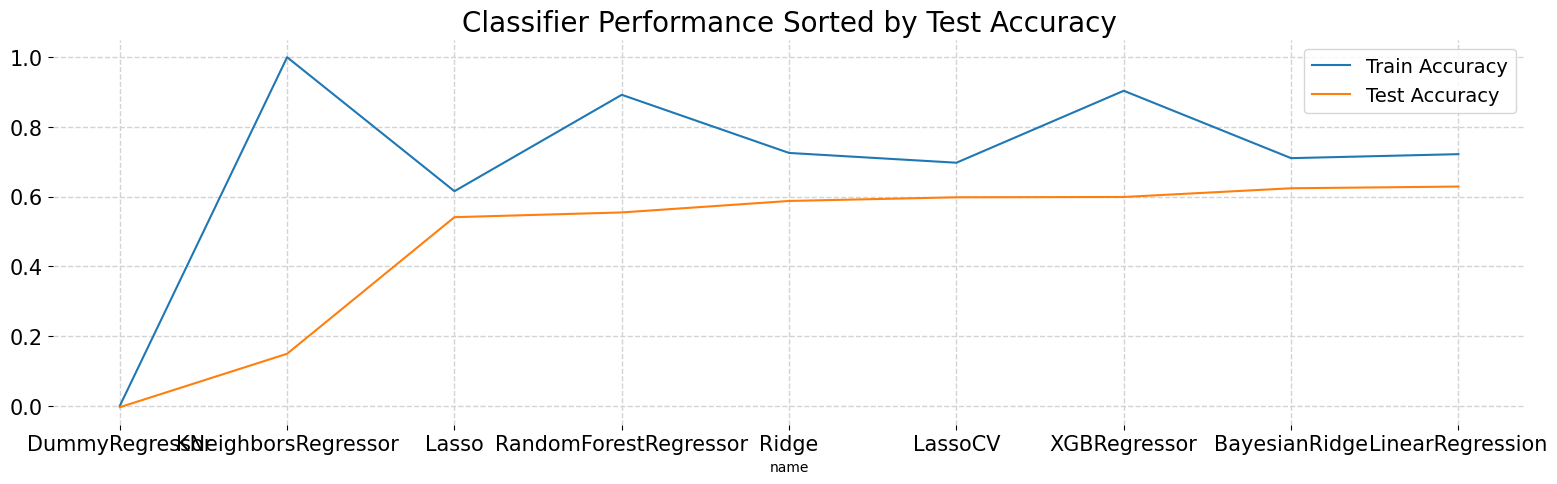

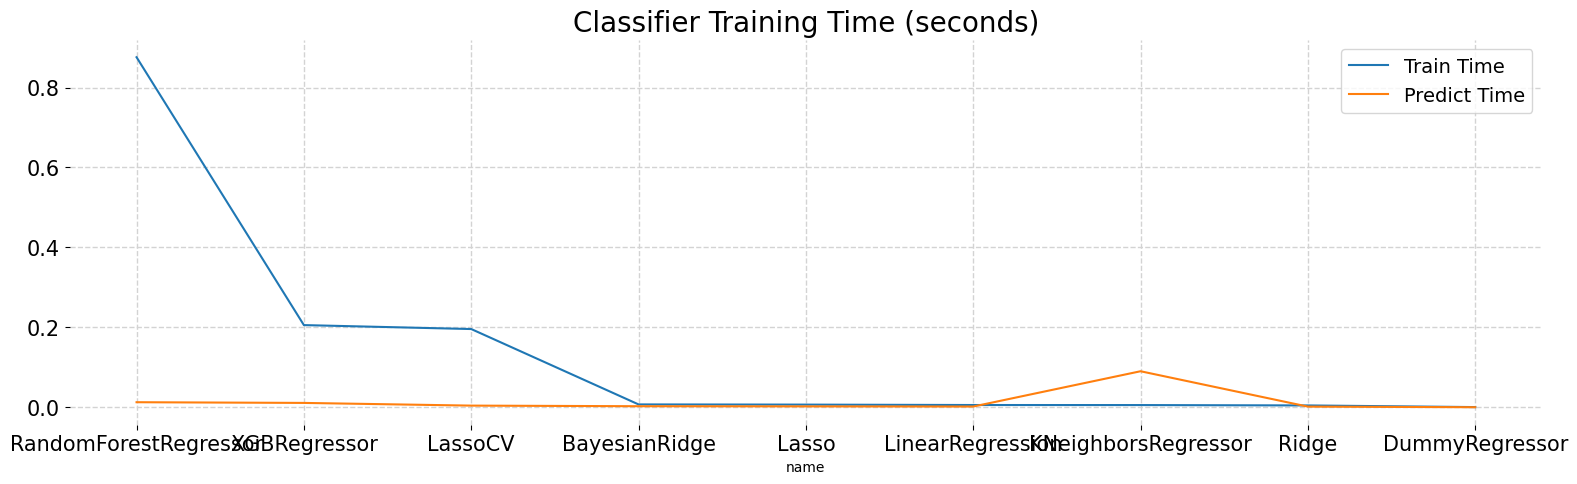

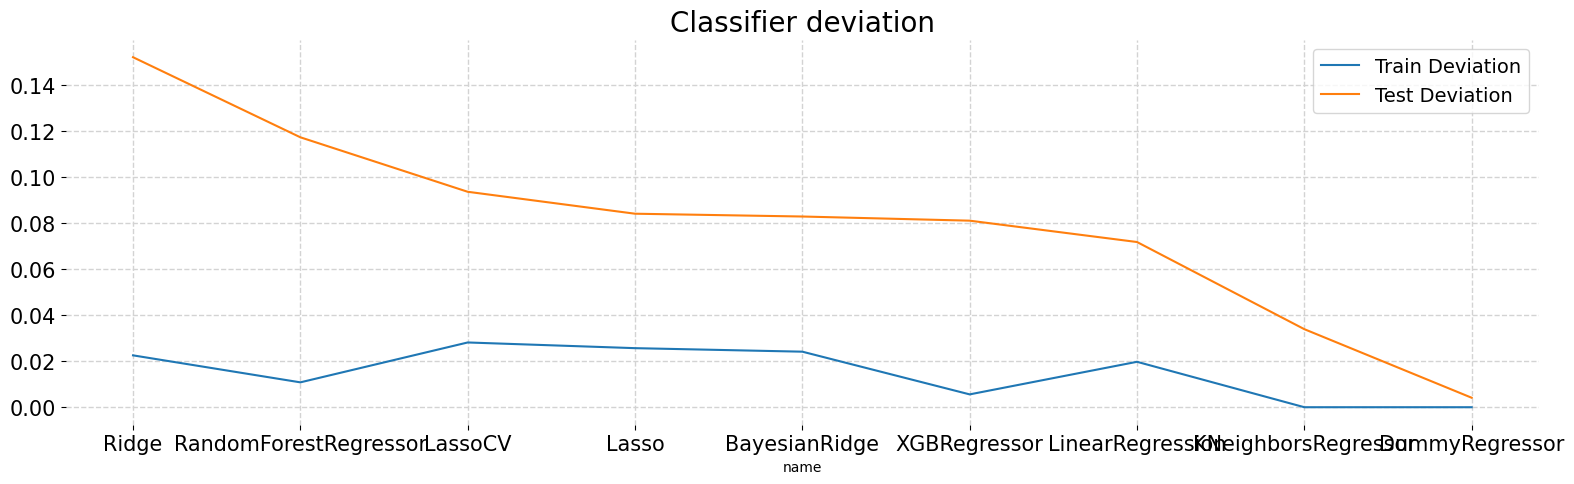

In [20]:
import time
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

trained_models = [] #  keep track of all details for models we train
def train_model(model, data, labels): 
    X = data
    y = labels
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

    
    start_time = time.time()
    trained_model = model["clf"].fit(X_train, y_train)
    train_time = time.time() - start_time

    
    start_time = time.time()
    y_pred = trained_model.predict(X_test)
    predict_time = time.time() - start_time
    
    test_score = metrics.r2_score(y_test, y_pred)
    
    y_pred = trained_model.predict(X_train)
    train_score = metrics.r2_score(y_train, y_pred)
    
    model_details = {"name": model["name"], "test_accuracy": test_score, "train_accuracy": train_score, "train_time": train_time, "predict_time": predict_time}
    return model_details

models = [
          {"name": "Dummy Regressor", "clf": dummy.DummyRegressor()},
          {"name": "KNN", "clf": KNeighborsRegressor(n_neighbors=10, weights='distance')},
          {"name": "LassoCV", "clf": LassoCV(cv=50)}, 
          {"name": "Lasso", "clf": Lasso(alpha=0.1)},
          {"name": "RandomForestRegressor", "clf": RandomForestRegressor(max_depth=75)},
          {"name": "Ridge", "clf": Ridge(alpha=0.89)}, 
          {"name": "LinearRegression", "clf": LinearRegression()}, 
          {"name": "BayesianRidge", "clf": BayesianRidge()},
          {"name": "Best Model", "clf": best_model}]

for model in list_models*25:
    model_details = train_model(model, data_X[col_num], data_Y['Energy_Y']) 
    trained_models.append(model_details)


# visualize accuracy and run time
setup_plot()
model_df = pd.DataFrame(trained_models).groupby('name').mean()
model_df.sort_values("test_accuracy", inplace=True) 
ax = model_df[["train_accuracy","test_accuracy"]].plot(kind="line", figsize=(19,5), title="Classifier Performance Sorted by Test Accuracy")
ax.legend(["Train Accuracy", "Test Accuracy"])
ax.title.set_size(20)
plt.box(False)

model_df.sort_values("train_time", inplace=True, ascending=False)
ax= model_df[["train_time", "predict_time"]].plot(kind="line", figsize=(19,5), grid=True, title="Classifier Training Time (seconds)")
ax.title.set_size(20)
ax.legend(["Train Time", "Predict Time"])
plt.box(False)  


model_df = pd.DataFrame(trained_models).groupby('name').std()
model_df.sort_values("test_accuracy", inplace=True, ascending=False)
ax= model_df[["train_accuracy","test_accuracy"]].plot(kind="line", figsize=(19,5), grid=True, title="Classifier deviation")
ax.title.set_size(20)
ax.legend(["Train Deviation", "Test Deviation"])
plt.box(False) 

In [21]:
import shap

In [22]:
shap.initjs()

In [23]:
shap_model = LassoCV(cv=5)
shap_model.fit(data_X[col_num], data_Y['Energy_Y'])

explainer = shap.LinearExplainer(shap_model, data_X[col_num], feature_names=col_num)
shap_values = explainer.shap_values(data_X[col_num])

In [24]:
shap_model = XGBRegressor().fit(data_X[col_num], data_Y['Energy_Y'])

In [25]:
explainer = shap.Explainer(shap_model, feature_names=col_num)
shap_values = explainer.shap_values(data_X[col_num])

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [26]:
shap.force_plot(explainer.expected_value, shap_values[0], feature_names=col_num)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


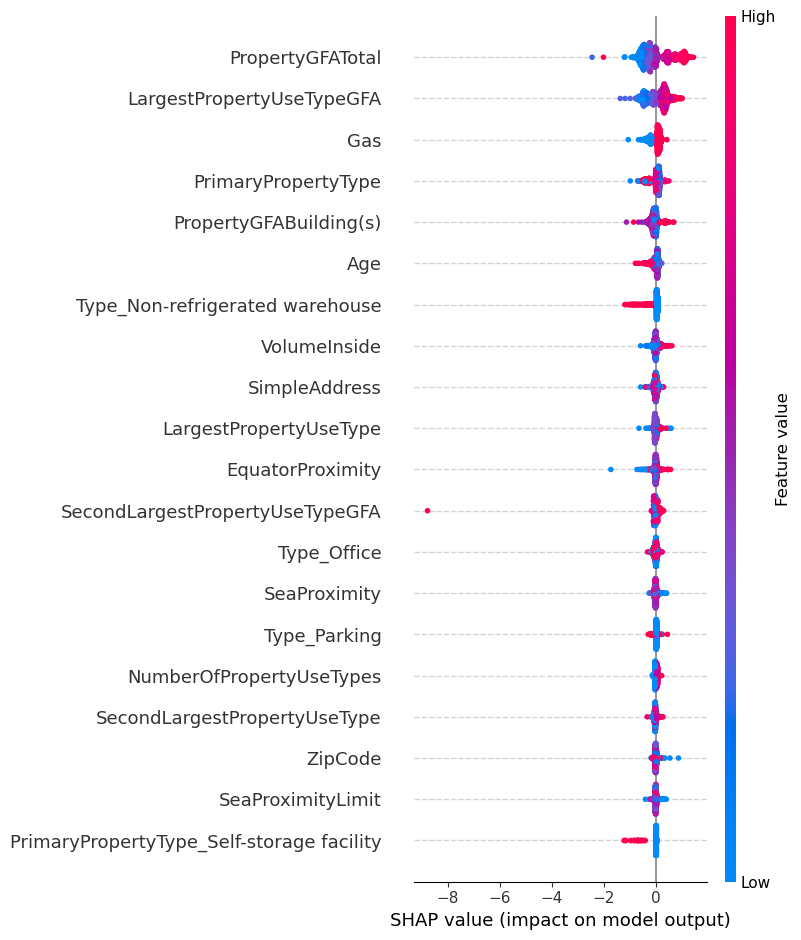

In [27]:
shap.summary_plot(shap_values, data_X[col_num])

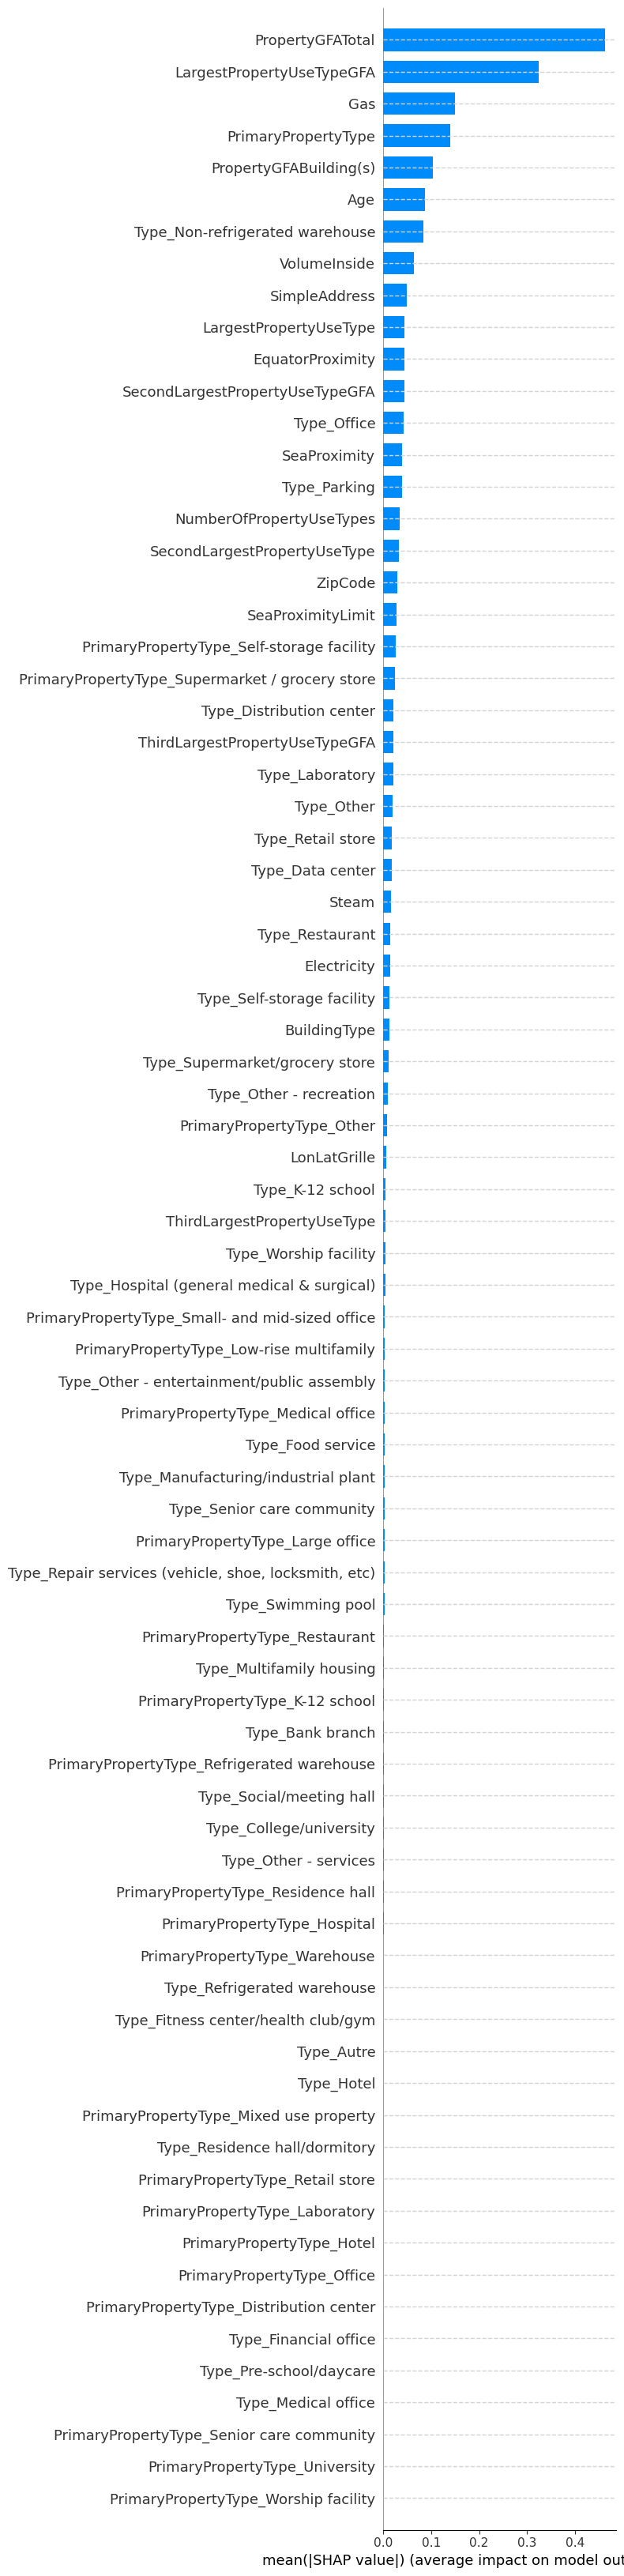

In [28]:
shap.summary_plot(shap_values, data_X[col_num], plot_type="bar", max_display=150)